#### TensorBoard


> Quando o TensorBoard é iniciado uma vez, fechamos a aba do TensorBoard e tentamos acessar novamente pelo plugin do VSCode dá erro.
> Porém, se fechar e abrir novamente o VSCode ou acessar http://localhost:6006 funciona. Outra opção é iniciar o TensorBoard via linha de comando conforme instrução abaixo. Mais detalhes em: https://github.com/microsoft/vscode-jupyter/issues/9467.

        
    $ tensorboard --logdir ./path/to/runs/
        

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter

Showing images

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', 
    train = True, 
    transform=transform, 
    download=True)

validation_set = torchvision.datasets.FashionMNIST('./data', 
    train=False, 
    transform=transform, 
    download=True)

training_loader = torch.utils.data.DataLoader(dataset=training_set, 
    batch_size=4, 
    num_workers=2, 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
    batch_size=4, 
    num_workers=2, 
    shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [22]:
def matplotlib_imgshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim = 0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

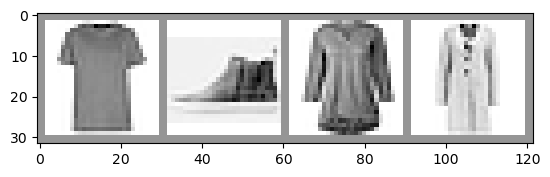

In [25]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imgshow(img_grid, one_channel=True)

In [26]:
writer = SummaryWriter('runs/fashio_mnist_experiment_1')

writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

In [37]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [38]:
print(len(validation_loader))
for epoch in range(1):
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('Batch {}'.format(i + 1))

            running_vloss = 0.0

            net.train(False)
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            writer.add_scalars('Traning vs Validation Loss', {'Training' : avg_loss, 'Validation' : avg_vloss}, 
                               epoch * len(training_loader) + i)
            
            running_loss = 0.0

print('Finished Training')

writer.flush()


2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


Visualizing Your Model

In [40]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

writer.add_graph(net, images)
writer.flush()

##### Visualizing Your Dataset with Embeddings

In [42]:
def select_n_random(data, labels, n = 100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(training_set.data, training_set.targets)

class_labels = [classes[label] for label in labels]

features = images.view(-1, 28 * 28)

writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.flush()
writer.close()